# Train the networks for modulation recognition

## Preambule

In [1]:
# Authors: Hélion du Mas des Bourboux <helion.dumasdesbourboux'at'thalesgroup.com>
#         Thomas Courtat <thomas.courtat'at'thalesgroup.com>

# MIT License

# Copyright (c) 2021 Thales Six GTS France

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

### Imports

In [2]:
import sys
from os import mkdir
from os.path import exists as path_exists
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from tensorflow import convert_to_tensor
from tensorflow.keras.backend import clear_session

print(f'Tensorflow version {tensorflow.__version__}')
print(f'Available devices:\n{[x.name for x in device_lib.list_local_devices()]}')


from pythagore_modreco.data import read_augmod, read_RML2016, read_RML2018
from pythagore_modreco.utils import TimeHistory,split_dataset
from pythagore_modreco import neural_nets_keras


np.random.seed(2015)

Tensorflow version 2.2.0
Available devices:
['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


### General settings

In [3]:
# Please specify the folder where your dataset(s) is/are
data_path = <your data path>

# Please specify a folder to log information during model training 
log_path = <your log path>

if not path_exists(log_path):
    mkdir(log_path)

#### Dataset settings

In [4]:
# Please chose a dataset name from:
# AugMod
# RadioML2016.04c
# RadioML2016.10a
# RadioML2016.10b
# RadioML2018.01a
dataset_name = "AugMod"

# Please choose signal duration in seconds. 
# Beware, that duration should be less or equal to the chosen dataset signal lengths
# Set to None if you want to take as much as there is in the dataset
signal_duration = 1024

# Please choose a cut in SNR
# The resulting dataset will consit in all data>=snr_cut
# set to None if no cut
snr_cut = 0.

#### Trainning settings

In [5]:
nb_epoch = 200
batch_size = 512

## Data loading and preparation

Load the selected dataset ; 

This cell outputs: 
- signals : a numpy array containing signal data 
- class_onehot : a numpy array containing one hot encoded labels associated to data 
- snrs: an array associating snr to each signal 
- class_list: a list of strings associating the modulation / signal kind name to the indexes of labels

In [6]:
if dataset_name == "AugMod":
    
    fName = join(data_path,'augmod.hdf5')
    data_dict = read_augmod(fName)
    
    signals  = data_dict['signals']
    class_idx = data_dict['modulations']
    snrs = data_dict['snr']
    
    class_onehot = to_categorical(class_idx)
    class_list = data_dict['classes']
    
elif dataset_name == "RadioML2016.04c":

    fName = join(data_path,'2016.04C.multisnr.pkl')
    
    signals, class_idx, snrs, class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)
    
elif dataset_name == "RadioML2016.10a":

    fName = join(data_path,'RML2016.10a_dict.pkl')
    
    signals, class_idx, snrs,class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)
    
elif dataset_name == "RadioML2016.10b":

    fName = join(data_path,'RML2016.10b.dat')
    
    signals, class_idx, snrs,class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)
    
elif dataset_name == "RadioML2018.01a":

    fName = join(data_path,'GOLD_XYZ_OSC.0001_1024.hdf5')
    
    signals, class_onehot, snrs ,class_list = read_RML2018(fName)
    #snrs = snrs.reshape(-1)
    class_idx = np.argmax(class_onehot,axis=-1)
else: 
    print('Data not found')

In [7]:
snrs_list = sorted( list( set( snrs ) ) )
print(f'{dataset_name} loaded, {signals.shape[0]} signal with shape {signals.shape[1:]}' )
print(f'List of signal SNR: {snrs_list}')
print(f'List of modulations under consideration: {class_list}')

AugMod loaded, 174720 signal with shape (2, 1024)
List of signal SNR: [0.0, 10.0, 20.0, 30.0, 40.0]
List of modulations under consideration: ['BPSK', 'PSK8', 'QAM16', 'QAM32', 'QAM64', 'QAM8', 'QPSK']


Transposes the data so the real/imag axis is the last as expected by deep learning models

In [8]:
print(f'Initial data shape: {signals.shape}')
signals = signals.transpose((0,2,1))
print(f'Transposed data shape: {signals.shape}' )

Initial data shape: (174720, 2, 1024)
Transposed data shape: (174720, 1024, 2)


Trunk signal to `signal_duration`samples. 

In [9]:
if not signal_duration is None:
    print(f'Initial data shape: {signals.shape}')
    signals = signals[:,:signal_duration,:]
    print(f'Trunked data shape: {signals.shape}' )

Initial data shape: (174720, 1024, 2)
Trunked data shape: (174720, 1024, 2)


Filters signal by snr if requested above

In [10]:
if not snr_cut is None:
    print(f'Initial data shape: {signals.shape}')
    w = snrs>=snr_cut
    signals = signals[w]
    class_idx = class_idx[w]
    snrs = snrs[w]
    class_onehot = class_onehot[w]
    print(f'New data shape: {signals.shape}' )

Initial data shape: (174720, 1024, 2)
New data shape: (174720, 1024, 2)


Normalize the power of each signal

In [11]:
### Normalize the power of each signal
norm = np.sqrt(np.mean(signals**2,axis=(1,2),keepdims=True))
signals/=norm

Split dataset into train and test sets. Also shuffles data.

In [12]:
X_train, y_train, train_idx ,_,_,_, X_test,y_test,test_idx= split_dataset(signals, 
    class_onehot, 
    p_train=0.5,p_test=0.5)

SNR_train = snrs[train_idx]
SNR_test = snrs[test_idx]

print(f'Train dataset shape: {X_train.shape}')
print(f'Test dataset shape: {X_test.shape} ')

Train dataset shape: (87360, 1024, 2)
Test dataset shape: (87360, 1024, 2) 


In [13]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}, y_test  shape: {y_test.shape}')

input_shp = list(X_train.shape[1:])
output_shp = y_train.shape[1]

print(f'Network input shape in variable input-shp: {input_shp}')
print(f'Network output shape in variable input-shp: {output_shp}')

X_train shape: (87360, 1024, 2), y_train shape: (87360, 7)
X_test  shape: (87360, 1024, 2), y_test  shape: (87360, 7)
Network input shape in variable input-shp: [1024, 2]
Network output shape in variable input-shp: 7


In [14]:
X_train = convert_to_tensor(X_train)
y_train = convert_to_tensor(y_train)
X_test = convert_to_tensor(X_test)
y_test = convert_to_tensor(y_test)

## Deep learning model training 

Define a function to instanciate and train a deep learning model

In [15]:
def train_model(model,name_network): 
    
    clear_session()
    time_callback = TimeHistory()

    history = model.fit(X_train, y_train,
                        epochs=nb_epoch, batch_size=batch_size,
                        validation_data =( X_test , y_test ), 
                        verbose=1,
                        callbacks=[time_callback])

    model.save(join(log_path,'model-{}-{}-trained{}.h5'.format(dataset_name,name_network,signal_duration)))

    data = np.array(list(zip(history.epoch, history.history['val_accuracy'], history.history['accuracy'])))
    np.savetxt(join(log_path,'history-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)),data)

    data = np.array(list(zip(history.epoch, time_callback.times)))
    np.savetxt(join(log_path,'history_time-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)),data)
    
    clear_session()

### LModCNN (ours)

Generate LModCNN architecture as defined in Courtat and du Mas des Bourboux, <i>A light neural network for modulation detection under impairments</i>, ISNCC 2021


In [16]:
name_network = "LModCNN"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1024, 8)           120       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 16)          912       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1024, 32)          3616      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 64)          14400     
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

### LModCNNResNet Relu (ours)

Generate LModCNN with residual connexion architecture as defined in Courtat and du Mas des Bourboux, <i>A light neural network for modulation detection under impairments</i>, ISNCC 2021

In [17]:
name_network = "LModCNNResNetRelu"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1024, 8)      24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1024, 8)      456         conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1024, 8)      456         conv1d_5[0][0]                   
______________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

### RMLConvNet

Generate RMLConvNet as defined in O'Shea et Al., <i>Convolutional radio modulation recognition networks</i>, 2016
The implementation is an adaptation of
https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb


In [18]:
name_network = "RMLConvNet"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1024, 2, 1)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1028, 2, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1026, 2, 256)      1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1026, 2, 256)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1030, 2, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1028, 1, 80)       122960    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1028, 1, 80)      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

### RMLCNNVGG

Generate RML CNN/VGG  as defined in O'Shea et Al., <i>Over-the-Air Deep Learning Based Radio Signal Classification</i>,  2018. The implementation is an adaptation of https://github.com/leena201818/radioml/blob/master/rmlmodels/VGGLikeModel.py


In [19]:
name_network = "RMLCNNVGG"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 1024, 64)          960       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 512, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 512, 64)           28736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 256, 64)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 256, 64)           28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 128, 64)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 128, 64)          

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

### RMLResNet
Generate RML Residual Network  as defined in O'Shea et Al., <i> Over-the-Air Deep Learning Based Radio Signal Classification</i>,  2018. 
The implementation is an adaptation of https://github.com/liuzhejun/ResNet-for-Radio-Recognition/blob/master/ResNet_Model.ipynb


In [20]:
name_network = "RMLResNet"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 2)]    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1024, 2, 1)   0           input_2[0][0]                    
__________________________________________________________________________________________________
ReStk1_conv1 (Conv2D)           (None, 1024, 2, 32)  64          reshape_1[0][0]                  
__________________________________________________________________________________________________
ReStk1_conv2 (Conv2D)           (None, 1024, 2, 32)  6176        ReStk1_conv1[0][0]               
____________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

## Results and comparisons

In [21]:
from_name_to_legend = {
    'RMLConvNet':'RML-ConvNet',
    'RMLCNNVGG':'RML-CNN/VGG',
    'RMLResNet':'RML-ResNet',
    'LModCNN':'Mod-LCNN (ours)',
    'LModCNNResNetRelu':'Mod-LRCNN (ours)',
}

networks_to_plot = ['RMLConvNet','RMLCNNVGG','RMLResNet','LModCNN','LModCNNResNetRelu' ]

### Plot training trajectories

Plots the evolution of error through learning epochs both for train and test dataset.

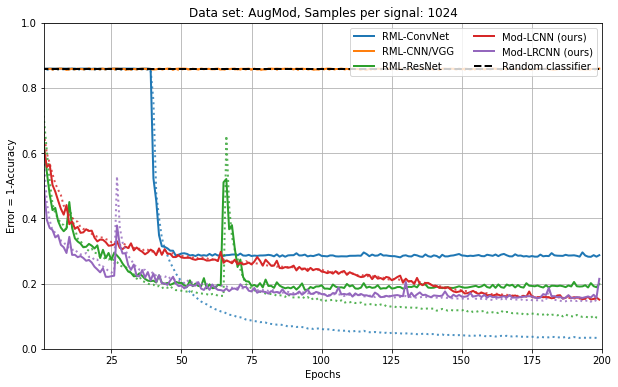

In [22]:
plt.figure(figsize=(10,6))

for name_network in networks_to_plot:

    data = np.loadtxt(join(log_path,'history-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)))

    p = plt.plot(data[:,0], 1.-data[:,1],
        label=from_name_to_legend[name_network],linewidth=2)
    plt.plot(data[:,0], 1.-data[:,2],':',
        linewidth=2,color=p[0].get_color(),alpha=0.8)

plt.plot(data[:,0] ,1.-1./output_shp*np.ones_like(data[:,0]),
    '--',label='Random classifier',linewidth=2,color='black')

plt.legend(ncol=2,loc=1)
plt.grid()
plt.ylabel('Error = 1-Accuracy')
plt.xlabel('Epochs')
plt.title(f'Data set: {dataset_name}, Samples per signal: {signal_duration}')
plt.ylim([0.,1.])
plt.xlim([1,nb_epoch])
plt.savefig(join(log_path,'network_comparison_{}-trained{}.pdf'.format(dataset_name,signal_duration)))
plt.show()

Solid curves are for the test set and dotted curves for the training set

Lower is better

### Print final performances

Displays test accuracy for different algorithmes and train/test computation time

In [ ]:
f = open(join(log_path,'perfs-{}-{}-trained{}.txt'.format(dataset_name,'all',signal_duration)), 'w')

f.write(f'#Performance evaluations, Data set: {dataset_name}, Samples per signal: {signal_duration}\n')
    
f.write(f"#{'':20s}{'Loss':15s}{'Accuracy':15s}{'Training time':20s}{'Inference time':20s}{'# Parameters':15s}\n")
f.write(f"#{'':20s}{'':15s}{'':15s}{'(s/epoch)':20s}{'(ms/signal)':20s}\n")
f.write(f"#{'-'*110}\n")

for name_network in from_name_to_legend.keys():
    
    training_time_vec=  np.loadtxt(join(log_path,'history_time-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)))
    training_time = training_time_vec[:,1].mean()
    
    model = load_model(join(log_path,'model-{}-{}-trained{}.h5'.format(dataset_name,name_network,signal_duration)))
    mod_size = model.count_params()
   
    t = time.time()
    test_loss, test_acc = model.evaluate(X_test, y_test,
        verbose=False,batch_size=batch_size)
    t_proc= 1000.0*(time.time()-t)/X_test.shape[0] #ms

    f.write(f"{from_name_to_legend[name_network]:20s}{test_loss:2.3f}{'':10s}{test_acc:2.3f}{'':10s}{training_time:>4.1f}{'':17s}{t_proc:>4.2}{'':16s}{mod_size:>10,d}\n")

f.close()

In [24]:
f = open(join(log_path,'perfs-{}-{}-trained{}.txt'.format(dataset_name,'all',signal_duration)), 'r')
print(f.read())
f.close()

#Performance evaluations, Data set: AugMod, Samples per signal: 1024
#                    Loss           Accuracy       Training time       Inference time      # Parameters   
#                                                  (s/epoch)           (ms/signal)         
#--------------------------------------------------------------------------------------------------------------
RML-ConvNet         0.849          0.713          49.6                 0.19                21,179,479
RML-CNN/VGG         1.946          0.141          10.4                 0.25                   256,455
RML-ResNet          1.329          0.801          31.3                 0.48                   236,647
Mod-LCNN (ours)     0.352          0.849           9.4                 0.15                    37,487



In [25]:
clear_session()